## Fashion MINST classification with Pytorch.

#### Objective:

The following notebook consist of a convolutional neural network to classify the images of the Fashion MINST dataset. The purpose of this exercise is to get used to and explore Pytorch's ecosystem for Machine learning.

#### Import dataset and necessary libraries.

The models used belong to the Pytorch ecosystem, however numpy and the dataset from keras do not belong to Pytorch but are used as part of the exercise.

For the case of the dataset, it could have been imported from Pytorch but the dataset from  the keras library was used in order to practice preprocessing and data adjustments from other sources and avoid using a dataset directly provided by pytorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tensorflow.keras import datasets as dt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test)= dt.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Once the dataset is downloaded a summary of its shape is displayed to confirm it is divided in training and test set.

In [ ]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


A dictionary object is created with the names of the clothes and their numerical reference to understand the outputs.

In [ ]:
mnist_classes= {0:"T-shirt/top",
                1:"Trouser",
                2:"Pullover",
                3:"Dress",
                4:"Coat",
                5:"Sandal",
                6:"Shirt",
                7:"Sneaker",
                8:"Bag",
                9:"Ankle boot"}

## Preparing the dataset.

In order to have a useful dataset for Pytorch a Dataset class is implemented with three necessary functions: __init__, __len__, and __getitem__. The purpose of this class is to create the dataset object that returns the sample and label and perform the necessary transformations.

The data object will only apply one transformation, it will change the data of the samples to a tensor. It's important to remember that Pytorch works with tensors.

In [ ]:
class dataset1(Dataset):
    def __init__(self, labels, X, transform=None):
        self.y= labels
        self.X = X
        self.transform = transform



    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)

        return image, label

The dataset object is created using the raw data that was downloaded from Keras and divided in three; one part as a training set, the second part as an evaluation dataset and finally a third division to test the model.

In [ ]:
data_training = dataset1(labels=y_train, X=x_train, transform= transforms.ToTensor())
data_eval = dataset1(labels=y_test[:3000], X=x_test[:3000], transform=transforms.ToTensor())
data_testing =dataset1(labels=y_test[3000:], X=x_test[3000:], transform=transforms.ToTensor())

#### An example of the first sample converted to a tensor.

It is interesting to see that the transformation not only turns the image into a tensor but it also "normalizes" the inputs between 0 and 1. This shows the capabilities of pytorch for handling, preprocessing and transforming data.

In [ ]:
data_training[0]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### Dataloader
The dataloader helps with the retrival of the data; it shuffles, divides in batches etc. all of the data.

During training the dataloader, "loads" the data to the model as needed.

In [ ]:
train_dataloader = DataLoader(data_training, batch_size=32, shuffle=True)
eval_dataloader = DataLoader(data_eval, batch_size=32, shuffle=True)
test_dataloader = DataLoader(data_testing, batch_size=32, shuffle=True)

### Building the model.

For the model it is necessary to create another class that inherits the attributes and methods of nn.Module; all of this with the purpose of having flexibility when building the model.

Another aspect that is important in the model class definition is the "forward" function, which allows the model to perform the computations through the model.

In [ ]:
class FashionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1 = nn.Conv2d(1, 16, kernel_size=(3,3), stride=1, padding="same")
        self.activation1 = nn.ReLU()
        self.batchn1  = nn.BatchNorm2d(16)

        self.convolution2 = nn.Conv2d(16, 32, kernel_size=(3,3), stride=1, padding="same")
        self.activation2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.batchn2  = nn.BatchNorm2d(32)

        self.convolution3 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding="same")
        self.activation3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2))
        self.batchn3  = nn.BatchNorm2d(32)

        self.flatten4 = nn.Flatten()
        self.linear4 = nn.Linear(1568,256)
        self.activation4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.linearfinal = nn.Linear(256, 10)


    def forward(self, x):

        x = self.activation1(self.convolution1(x))
        x = self.activation2(self.convolution2(x))
        x = self.maxpool2(x)
        x = self.activation3(self.convolution3(x))
        x = self.maxpool3(x)
        x = self.flatten4(x)
        x = self.activation4(self.linear4(x))
        x = self.dropout4(x)

        x = self.linearfinal(x)
        return x

### Training

To train the model a "for" loop is applied according to the desired number of epochs that the model will be trained.

After some epochs the model will stop improving; it is important to keep in mind the simplicity of the exercise presented here. There are more ways to improve the accuracy and performance of the model. For example, more transformations, normalization of the tensors, a different setting of the model etc. Despite of this, the model still reaches an accuracy of over 90% with the validation dataset.

In [ ]:
model = FashionModel()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
for epoch in range(1, epochs+1):
    for input, label in train_dataloader:
        # forward, backward, and then weight update
        y_pred = model(input)
        loss1 = loss(y_pred, label)
        optimizer.zero_grad()
        loss1.backward()
        optimizer.step()

    accuracy = 0
    count = 0
    for inputs, labels in eval_dataloader:
        y_pred = model(inputs)
        accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    accuracy /= count
    print("Epoch's %d accuracy: %.2f%%" % (epoch, accuracy*100))

Epoch's 1 accuracy: 86.60%
Epoch's 2 accuracy: 88.23%
Epoch's 3 accuracy: 89.17%
Epoch's 4 accuracy: 89.93%
Epoch's 5 accuracy: 89.93%
Epoch's 6 accuracy: 90.67%
Epoch's 7 accuracy: 90.77%
Epoch's 8 accuracy: 90.97%
Epoch's 9 accuracy: 91.60%
Epoch's 10 accuracy: 90.50%
Epoch's 11 accuracy: 91.37%
Epoch's 12 accuracy: 91.50%
Epoch's 13 accuracy: 90.30%
Epoch's 14 accuracy: 91.20%
Epoch's 15 accuracy: 90.93%


For each epoch of training the loop outputs the accuracy of the validation dataset as a reference of how the model is training and improving.

It is important to consider that this "accuracy" is only a reference of the training performance and the use of the validation set. It is also necessary to make the model deal with unseen data and discover if the model is overfitted or has learned features, patterns or functions that make the right inference and provide high accuracy.

#### Evaluating the model.

In Pytorch once the model has finished the training phase, it is ready to be evaluated. For this, a function call is made to change the model  from 'training' to 'inference' (evaluating) mode.

This means that certain features are not functioning as they would while training; basically the model stops learning and just makes inferences without affecting the learned parameters.

In [ ]:
model.eval()

FashionModel(
  (convolution1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activation1): ReLU()
  (batchn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activation2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (activation3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (batchn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten4): Flatten(start_dim=1, end_dim=-1)
  (linear4): Linear(in_features=1568, out_features=256, bias=True)
  (activation4): ReLU()
  (dropout4): Dropout(p=0.5, inplace=False)
  (linearf

The next code block outputs the shape of a random sample that will be used to infere a result. This is to have a reference of what kind of shape is necessary to work with the model and what to expect as an output.

In [ ]:
sample= np.random.randint(0, 7000)
print(sample)

y= data_testing[sample][1]
print(y)
print(data_testing[sample][0].size())
x = data_testing[sample][0]
x=torch.unsqueeze(x, 0)
print(x.size())

with torch.no_grad():
    outputs = model(x)
    max, max_indices = torch.max(outputs, dim=1)
print(max_indices)

2500
tensor(7, dtype=torch.uint8)
torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor([7])


#### A small test for 10 samples.

Time to test the model with some random samples. The code will output the model's prediction, the actual label and the image of the sample.

Prediction by the model:Sneaker 
Actual label:Sneaker


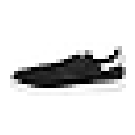

Prediction by the model:Sandal 
Actual label:Sandal


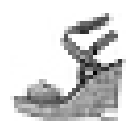

Prediction by the model:Shirt 
Actual label:Shirt


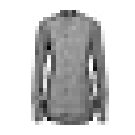

Prediction by the model:Pullover 
Actual label:Pullover


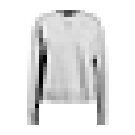

Prediction by the model:Pullover 
Actual label:Pullover


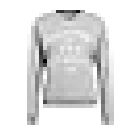

Prediction by the model:Sneaker 
Actual label:Sneaker


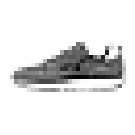

Prediction by the model:Sneaker 
Actual label:Sneaker


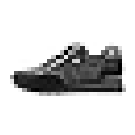

Prediction by the model:Trouser 
Actual label:Trouser


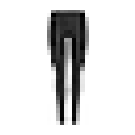

Prediction by the model:Trouser 
Actual label:Trouser


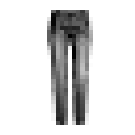

Prediction by the model:Trouser 
Actual label:Trouser


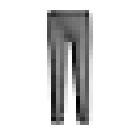

In [ ]:
import matplotlib.pyplot as plt
imgs=x_test[3000:]

with torch.no_grad():
    for test in range(1,11):
        sample= np.random.randint(0, 7000)
        y= data_testing[sample][1]

        x = data_testing[sample][0]
        x=torch.unsqueeze(x, 0)


        outputs = model(x)
        max, max_indices = torch.max(outputs, dim=1)
        predict = mnist_classes[max_indices.item()]
        label = mnist_classes[y.item()]
        print(f"Prediction by the model:{predict} \nActual label:{label}" )

        #plotting the image
        fig = plt.figure(figsize=(1.5, 1.5))


        plt.imshow(imgs[sample],cmap="Greys")
        plt.grid(False)
        plt.axis('off')
        plt.show()
        print("================================")


#### Inferring 5000 images to test the model's accuracy.

It's necessary to confirm the model's not overfitted and check if it has generalized the parameters well enough to have a constant and useful accuracy. Testing the model with 5000 samples will be a good way to see this.

In [ ]:
correct_total=0
with torch.no_grad():

    for test in range(0,5000):
        #sample= np.random.randint(0, 7000)
        sample= test
        y= data_testing[sample][1]

        x = data_testing[sample][0]
        x=torch.unsqueeze(x, 0)


        outputs = model(x)
        max, max_indices = torch.max(outputs, dim=1)
        predict = mnist_classes[max_indices.item()]
        label = mnist_classes[y.item()]
        if predict == label:
            correct_total += 1



test_result = (correct_total/5000) * 100

print(f"Percentege of correct predictions by the model:{test_result}%")

Percentege of correct predictions by the model:91.8%


The accuracy of the model is over 91%, 9 out of 10 samples are correctly inferred. This shows that the model is not overfitted and the parameters work to extract the features and functions that are required to make the inferences.

Pytorch and Deep learning in general are powerful tools. Despite the simplicty in the exercise, the results are a glimpse of what can be achieved, improved and created.